In [1]:
# Exploratory analysis of the data

In [2]:
%matplotlib inline

## Install some stuff you likely don't have
!pip3 -q install --upgrade pip
!pip3 -q install pandas_path
!pip3 -q install fasttext
!pip3 -q install umap-learn[plot]
!pip3 -q install ipywidgets --user

import json
import logging
from pathlib import Path
import random
import tarfile
import tempfile
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_path  # Path style access for pandas
from tqdm import tqdm

import torch                    
import torchvision
import fasttext

import os

from PIL import Image
import umap
import umap.plot

In [3]:
data_dir = "data" 
train_path = "data/train.jsonl"
dev_path = "data/dev_seen.jsonl"
test_path = "data/test_seen.jsonl"

print (train_path)

data/train.jsonl


In [62]:
train_samples_frame = pd.read_json(train_path, lines=True)
dev_frame = pd.read_json(dev_path, lines=True)

# Overview of data
train_samples_frame.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [63]:
dev_frame.head()

,id,img,label,text
0,8291,img/08291.png,1,white people is this a shooting range
1,46971,img/46971.png,1,bravery at its finest
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,img/80243.png,1,mississippi wind chime


In [64]:
def get_dev_images():
    image_ids = range(dev_frame.values.shape[0])
    
    images = [
        Image.open(
            os.path.join(data_dir,dev_frame.loc[i, "img"])
        ).convert("RGB")
        for i in image_ids
    ]
    
    labels = [
        dev_frame.loc[i, "label"]
        for i in image_ids
    ]
    
    image_transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(size=(224, 224)),
            torchvision.transforms.ToTensor()
        ]
    )
    
    tensor_img = torch.stack(
        [image_transform(image) for image in images]
    )
    
    labels = torch.from_numpy(np.array(labels))
    
    return tensor_img, labels

In [ ]:
def get_n_training_images(n, sample=True, maxi=False):
    
    if sample:
        image_ids = np.random.choice(train_samples_frame.values.shape[0], size=n)
    else:
        image_ids = range(n)
    
    if maxi:
        image_ids = range(train_samples_frame.values.shape[0])
    
    images = [
        Image.open(
            os.path.join(data_dir,train_samples_frame.loc[i, "img"])
        ).convert("RGB")
        for i in image_ids
    ]

    
    labels = [
        train_samples_frame.loc[i, "label"]
        for i in image_ids
    ]
    
    image_transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(size=(224, 224)),
            torchvision.transforms.ToTensor()
        ]
    )
    
    tensor_img = torch.stack(
        [image_transform(image) for image in images]
    )
    
    labels = torch.from_numpy(np.array(labels))
    
    return tensor_img, labels

In [51]:
def get_n_training_texts(n, sample=True):
    if sample:
        image_ids = np.random.choice(train_samples_frame.values.shape[0], size=n)
    else:
        image_ids = range(n)
        
    texts = [
        train_samples_frame.loc[i, "text"]
        for i in image_ids
    ]  
    
    return texts

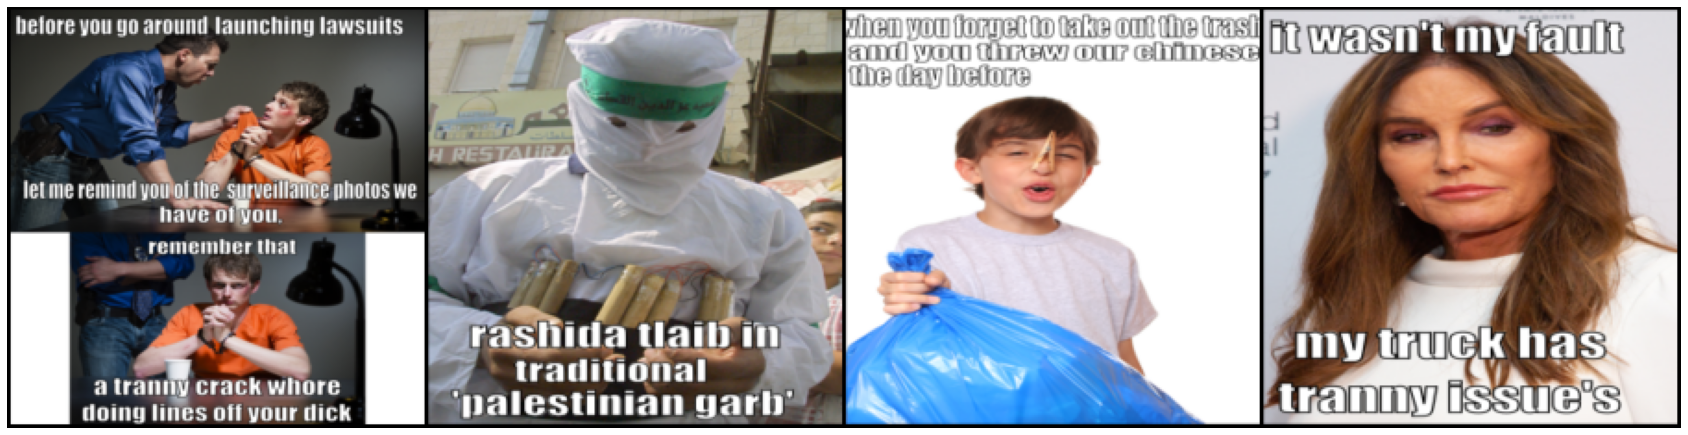

In [7]:
grid = torchvision.utils.make_grid(get_n_training_images(4)[0],nrow=4)

plt.rcParams["figure.figsize"] = (30, 10)
plt.axis('off')
_ = plt.imshow(grid.permute(1, 2, 0))

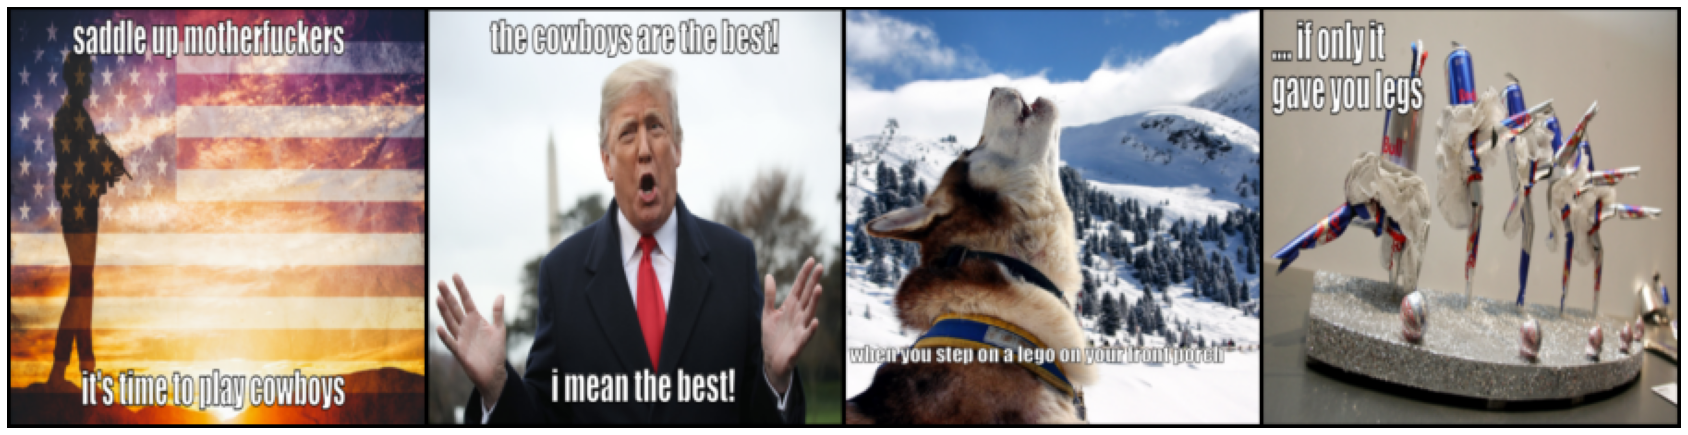

In [8]:
grid = torchvision.utils.make_grid(get_n_training_images(4)[0],nrow=4)

plt.rcParams["figure.figsize"] = (30, 10)
plt.axis('off')
_ = plt.imshow(grid.permute(1, 2, 0))

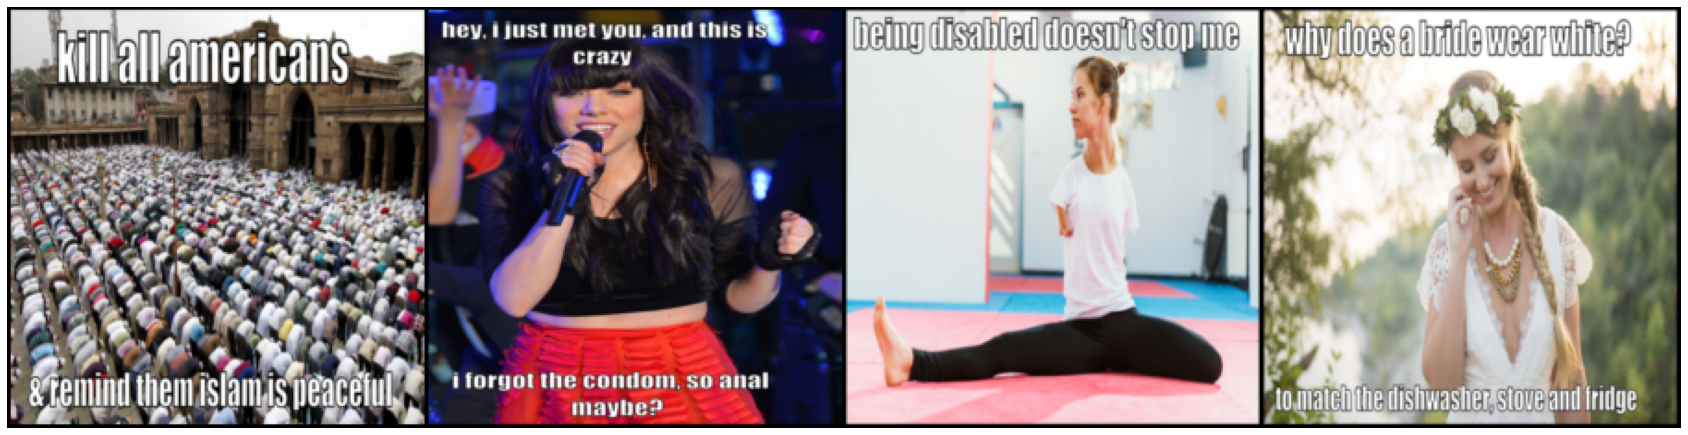

In [9]:
grid = torchvision.utils.make_grid(get_n_training_images(4)[0],nrow=4)

plt.rcParams["figure.figsize"] = (30, 10)
plt.axis('off')
_ = plt.imshow(grid.permute(1, 2, 0))

In [12]:
import umap
import umap.plot

In [14]:
run_umap=False

# Takes a while so leaving commented
if run_umap:
    umap_imgs, umap_lables = get_n_training_images(10_000)
    mapper = umap.UMAP(n_neighbors=5, min_dist=0.1).fit(umap_imgs.reshape(10_000, -1))
    umap.plot.points(mapper, labels=umap_lables)

UMAP isn't so interesting, there's a couple clusters but not so much.

In [15]:
### Topic modeling on texts
captions = get_n_training_texts(10_000)

In [16]:
print (captions[:5])

["questioning america's support for fascist israel ... is unacceptable", 'whats worse than a female driver?', "it's sad obama you had the chance of a lifetime to build a bridge, so we could all walk across it together instead you did everything you could in your power to divide us and make us hate one another, yeah, you built that!", 'you see that?? it means get the fuck back to the kitchen', "can't snort coke through a rolled-up bitcoin"]


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
n_features = 1000
n_components = 10
n_top_words = 20


In [18]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [19]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

In [20]:
tfidf = tfidf_vectorizer.fit_transform(captions)
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(captions)

In [21]:
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

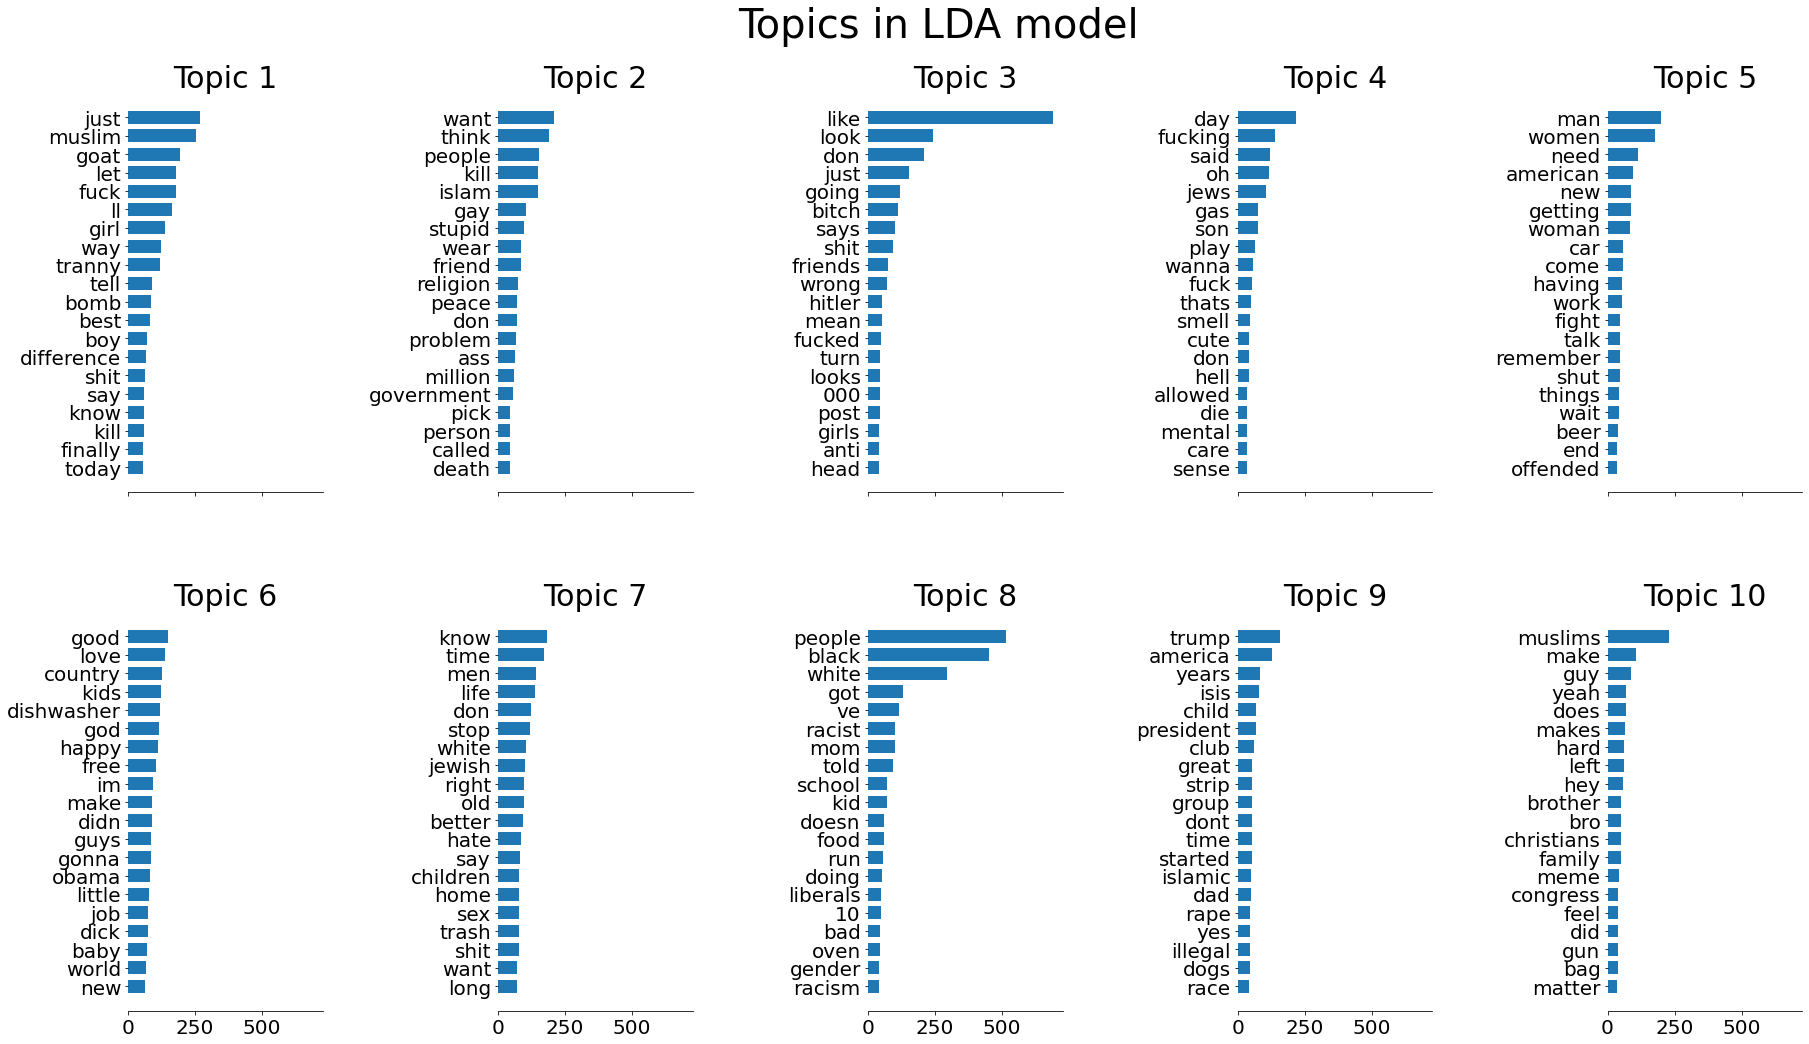

In [22]:
tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

Maybe some interesting things with "black" and "white" being put together... there's also things like "muslims" and "kill" being associated with eachother.

In [52]:
training_data_np = get_n_training_images(0, sample=False, maxi=True)

In [66]:
dev_data_np = get_dev_images()